# Classical LA methods
## $t$-test method

In [1]:
def nonzero_bins(bins):
    """
    Retrieves all bins for which at least one category has a non-zero value.

    :param bins: a set of categories with bins corresponding to that category.
    :return: the indexes of non-zero bins.
    """
    nz_bins = []
    for ix, a, b in zip(range(len(bins[0])), *bins):
        if a == 0 and b == 0:
            continue

        nz_bins.append(ix)

    return nz_bins


In [2]:
import scipy.stats as stats
import numpy as np
import math

def calc_t(ctable):
    mean = [0, 0]
    var = [0, 0]
    n = [0, 0]

    rg = [abs(a - b) for a, b in zip(*ctable)]

    for ix_cat in range(2):
        for ix_bin in range(len(ctable[ix_cat])):
            mean[ix_cat] += ctable[ix_cat][ix_bin] * rg[ix_bin]
            n[ix_cat] += ctable[ix_cat][ix_bin]

        mean[ix_cat] /= n[ix_cat]

        for ix_bin in range(len(ctable[ix_cat])):
            tmp = (rg[ix_bin] - mean[ix_cat])
            var[ix_cat] += tmp ** 2 + ctable[ix_cat][ix_bin]

        var[ix_cat] /= n[ix_cat]

    # t-value
    mean_diff = mean[0] - mean[1]
    var_sum = (var[0] / n[0]) + (var[1] / n[1])
    t_ret = mean_diff / math.sqrt(var_sum)

    # degree of freedom
    denom = ((var[0] / n[0]) * (var[0] / n[0])) / (n[0] - 1) + ((var[1] / n[1]) * (var[1] / n[1])) / (n[1] - 1)
    t_dof_ret = var_sum ** 2 / denom

    # cdf
    t_p_ret = 2 * stats.t(t_dof_ret).cdf(-abs(t_ret))

    return t_ret, t_dof_ret, t_p_ret

## $\chi^2$ method

In [3]:
def calc_chi(ctable):
    """
    Calculates the p value for rejecting H0, among others.
    Small p values give evidence to reject the null hypothesis and conclude that for the
    scenarios presented in ctable the occurrences of the observations are not independent.

    :param ctable: contingency table for different categories of traces.
    :return: A 3-tuple containing: The value for chi, the degrees of freedom,
        the p value for rejecting H0.
    """
    num_cats = len(ctable)
    num_bins = len(ctable[0])

    # chi**2 value
    sum_rows = [0] * num_cats
    sum_cols = [0] * num_bins
    N = 0.0

    # Only check non-zero bins
    nz_bins = nonzero_bins(ctable)

    for ix_bin in nz_bins:
        for ix_cat in range(num_cats):
            # Bin from the contingency table
            c_bin = ctable[ix_cat][ix_bin]

            sum_rows[ix_cat] += c_bin
            sum_cols[ix_bin] += c_bin
            N += c_bin

    chi = 0.0
    for ix_bin in nz_bins:
        for ix_cat in range(num_cats):
            E = (sum_rows[ix_cat] * sum_cols[ix_bin]) / N
            tmp = (ctable[ix_cat][ix_bin] - E)

            chi += tmp ** 2 / E

    # Degrees of freedom
    dof = (num_bins - 1) * (num_cats - 1)
    # p-value for rejecting H0
    p = stats.chi2(dof).cdf(chi)

    return chi, dof, p

In [4]:
from collections import Counter
import pandas as pd

def contingency_table(traces, trace_range):
        """
        Builds a contingency table from traces from the dataset for a given label.

        :param traces: the traces from which the contingency table should be build.
        :param trace_range: the range of values which the traces can take.
        :return: the contingency table as a numpy array.
        """
        df = pd.DataFrame([Counter(bins) for bins in traces])
        res = df.sum().sort_index().reindex(trace_range, fill_value=0).values
        return np.array(res, dtype=int)


## Testing the tests

<AxesSubplot:ylabel='Count'>

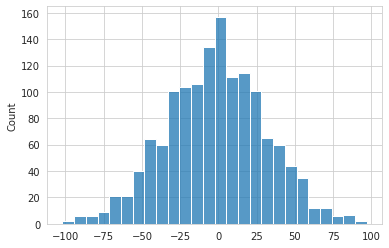

In [5]:
import seaborn as sns

def dist_gauss(mean=0, var=32, size=1400):
    return np.array(np.random.normal(mean, var, size), dtype=int)

sns.set_style("whitegrid")
sns.histplot(dist_gauss())

<AxesSubplot:xlabel='0', ylabel='1'>

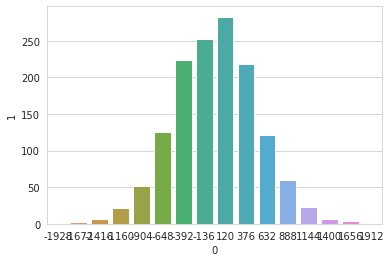

In [6]:
DEFAULT_TRACE_RANGE = range(-128, 128)

def c_table_gauss(num_traces=1, gauss_args=dict):
    return contingency_table(np.array([dist_gauss(**gauss_args) for _ in range(num_traces)]), DEFAULT_TRACE_RANGE)

left_args = {"size": 1400}
right_args = {"size": 1400, "var": 100, "mean": 100}

c_left = c_table_gauss(gauss_args=left_args)
c_left_alt = c_table_gauss(gauss_args=left_args)
c_right = c_table_gauss(gauss_args=right_args)

df = pd.DataFrame(zip(DEFAULT_TRACE_RANGE, c_left))
sns.barplot(x=0, y=1, data=df.groupby(df.index // 16).sum())

100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


<AxesSubplot:xlabel='Num traces'>

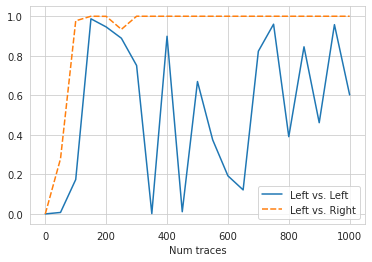

In [7]:
import tqdm

def plot_over():
    steps = np.linspace(0, 1000, 21, dtype=int)
    acc_left = np.zeros(len(steps))
    acc_right = np.zeros(len(steps))

    left_args = {"size": 1400}
    right_args = {"size": 1400, "var": 32.5, "mean": 0}

    for ix in tqdm.tqdm(list(reversed(range(len(steps))))):
        step = steps[ix]

        c_left = c_table_gauss(step, left_args)

        acc_left[ix] = calc_chi([c_left, c_table_gauss(step, left_args)])[2]
        acc_right[ix] = calc_chi([c_left, c_table_gauss(step, right_args)])[2]

    return pd.DataFrame(columns=["Num traces", "Left vs. Left", "Left vs. Right"], data=zip(steps, acc_left, acc_right)).set_index("Num traces", drop=True)

sns.lineplot(data=plot_over())

In [8]:
# Method described in paper is not working?
print(calc_t([c_left, c_left_alt]))
print(calc_t([c_left, c_right]))

(-0.6151937966915964, 2797.9505674809247, 0.5384767748543999)
(30.99364026911427, 1801.4177193703956, 2.0880972460566882e-169)


In [9]:
from settings.nbloader import NotebookLoader
wtt = NotebookLoader().load_module("welch_t_test")

tl = wtt.TraceProcessor()

importing Jupyter notebook from welch_t_test.ipynb
(0.0, 598.0, 1.0) (0.0, 99, nan)
(0.0, 300.3932780614927, 1.0) (2694.7380987472256, 99, 0.0)
False True


In [10]:
# Simulate signal! With SNR = .1